In [1]:
import os
import copy
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
from copy import copy
import seaborn as sn
#from scipy import ndimage
from scipy.interpolate import griddata, NearestNDInterpolator
from numpy import uint32, uint64, float64, float32, linspace, array, logspace, sin, cos, pi, arange
from arepy.read_write import binary_read as rsnap
from arepy.visualize import data_inspection as vis
from arepy.utility import snap_utility as snut
from scipy.optimize import curve_fit
from matplotlib import gridspec
from arepy.utility import cgs_constants as cgs
from scipy.spatial import Voronoi, Delaunay, ConvexHull, voronoi_plot_2d
from matplotlib import ticker
import copy
from read_snap import *
plt.style.use('classic')

In [2]:
### constants: 
kb = 1.38e-23
kb_cgs = 1.38e-16
mH = 1.67e-24
mu = 2.8
h = 6.626e-34
h_cgs = 6.62e-27
gamma = 5./3.
pc2cm = 3.086e18
msun2g = 2e33

distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

arepoLength = 3.0856e20
arepoMass = 1.991e33
arepoVel = 1.0e5

arepoTime = arepoLength/arepoVel
arepoDensity = arepoMass/arepoLength/arepoLength/arepoLength
arepoEnergy= arepoMass*arepoVel*arepoVel
arepoColumnDensity = arepoMass/arepoLength/arepoLength

In [3]:
##############################
### Auxillary Functions
##############################

def XYZ2lbr(X,Y,Z):
  r = sqrt(X**2+Y**2+Z**2)
  l = arctan2(Y,X)
  b = pi/2 - arccos(Z/r)
  return l,b,r

def lbr2XYZ(l,b,r):
  X = r*sin(b+pi/2)*cos(l)
  Y = r*sin(b+pi/2)*sin(l)
  Z = r*cos(b+pi/2)
  return X,Y,Z

def xyz2XYZ(x,y,z,R0=83.14):
  return x+R0,y,z

def XYZ2xyz(X,Y,Z,R0=83.14):
  return X-R0,Y,Z

def xyz2lbr(x,y,z):
  X,Y,Z = xyz2XYZ(x,y,z)
  l,b,r = XYZ2lbr(X,Y,Z)
  return l,b,r

In [15]:
##############################
### LOAD SNAPSHOT
##############################
path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/'
rsnap.io_flags['sgchem'] = True
rsnap.io_flags['mc_tracer']=True
file_suffix=str(105)
data, header = rsnap.read_snapshot(path+'whole_disk_'+file_suffix)

isnap = 105
omega = 4.0 # [omega] = km/s/100pc
halfbox, halfboy, halfboz = 120,120,120
#snapshot = Snapshot(isnap,path,halfbox,halfboy,halfboz)
#snapshot.read_full()

print "Done reading shapshot!"

Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/whole_disk_105
Particles [ 53651064         0 117899847         0         0         0]
Masses [0.         0.         5.35618115 0.         0.         0.        ]
Gas particles 53651064
Tracer particles 117899847
Time =  [1.00268501]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Done reading shapshot!


In [16]:
print data.keys()

['u_therm', 'chem', 'tracerid', 'pos', 'tdust', 'mass', 'rho', 'parentid', 'vel', 'numtrace', 'id']


In [16]:
###############################
### Define Auxillary Properties
###############################
utherm_cgs = data['u_therm']*(arepoEnergy/arepoMass)
Temps = (2.0/3.0)*utherm_cgs*mu*mh/kb_cgs

In [9]:
##############################
### DEFINE BASIC ROTATION FUNCTION IN 2D
##############################
def rotate(x,y,theta):
  xprime = x*cos(theta) - y*sin(theta)
  yprime = x*sin(theta) + y*cos(theta)
  return xprime, yprime

In [10]:
##############################
### Make general histograms
##############################

### Plot Histograms

#
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Cells')
axarr[0,0].set_xlabel('Cell Mass')

axarr[0,0].plot([25,25],[0,1e9],ls='--',label='25 M_$_odot$',color='k')

massmin, massmax = data['mass'].min(), data['mass'].max()
mass_linbins = np.logspace(np.log10(massmin), np.log10(massmax),20)
h1,l1,p1 = axarr[0,0].hist(data['mass'],
                   mass_linbins, color='cornflowerblue',alpha=0.7, log=True,
                   label='Arepo Cells')
h1,l1,p1 = axarr[0,0].hist(data['mass'],
                   mass_linbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='lower left')
axarr[0,0].set_ylim(0,1e9)

####
axarr[0,1].set_ylabel('Number of Cells')
axarr[0,1].set_xlabel('Cell Dust Temperature')

Tmin, Tmax = snapshot.T.min(),snapshot.T.max()

T_logbins = np.logspace(np.log10(Tmin), np.log10(Tmax),20)
h1,l1,p1 = axarr[0,1].hist(snapshot.T,
                   T_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='Arepo Cells')
h1,l1,p1 = axarr[0,1].hist(snapshot.T,
                   T_linbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='lower left')
####
axarr[1,0].set_ylabel('Number of Cells')
axarr[1,0].set_xlabel('Cell Density')

nP = snapshot.rho_cgs /(mu*mH)
nPmin, nPmax = nP.min(), nP.max()
nP_logbins = np.logspace(np.log10(nPmin), np.log10(nPmax),20)
h12,l1,p1 = axarr[1,0].hist(nP,
                   nP_logbins, color='firebrick',alpha=0.7, log=True,
                   label='Arepo Cells')
h12,l1,p1 = axarr[1,0].hist(nP,
                   nP_logbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[1,0].plot([1e3,1e3],[0,1e9],ls='--',label='n=1e3 cm$^{-3}$',color='k')
axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='lower left')
axarr[1,0].set_ylim(0,1e9)
####
axarr[1,1].set_ylabel('Number of Cells')
axarr[1,1].set_xlabel('Effective Radius')
reffmin, reffmax = snapshot.rcell.min(), snapshot.rcell.max()
reff_linbins = np.linspace(reffmin, reffmax,20)
h1,l1,p1 = axarr[1,1].hist(snapshot.rcell,
                   reff_linbins, color='mediumorchid',alpha=0.7, log=True,
                   label='Arepo Cells')
h1,l1,p1 = axarr[1,1].hist(snapshot.rcell,
                   reff_linbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[1,1].legend(loc='lower left')
####
plt.tight_layout()
plt.show()

NameError: name 'snapshot' is not defined

In [46]:
print masses.shape
print snapshot.masses.shape
print masses.max()
print snapshot.

(51241084,)
(51350511,)
99.99988


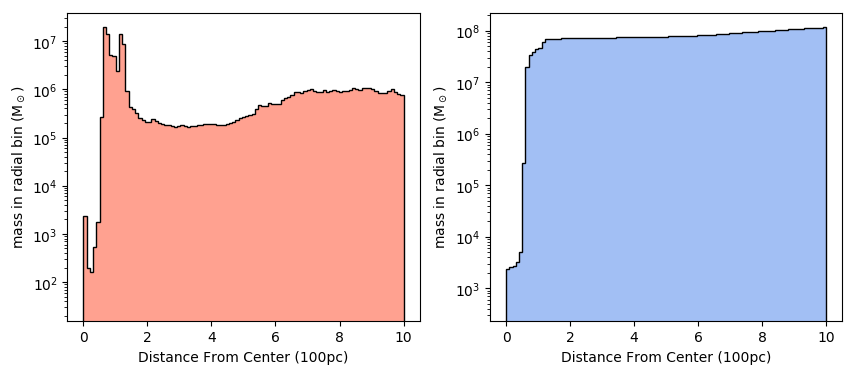

In [63]:
##############################
### Make vertical, radially binned mass plot
##############################
x,y,z = data['pos'].T
x,y,z = x-120, y-120, z-120
mass=data['mass']
r = ((x**2)+(y**2))**0.5

maxr = 10.
redges = np.linspace(0,maxr,100)
rgrid = (redges[:-1] + redges[1:])/2.0
dr = redges[1] - redges[0]
cond= (r<maxr)


plt.close()
fig, axarr = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
#dense_cond = (cond) & (mass[])

axarr[0].hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='stepfilled',alpha=0.6,color='tomato')
axarr[0].hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='step',alpha=1.,color='k')
#ax.hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='step',alpha=1.,color='k',cumulative=False)
axarr[0].set_xlabel('Distance From Center (100pc)')
axarr[0].set_ylabel('mass in radial bin (M$_\odot$)')

axarr[1].hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='stepfilled',alpha=0.6,
              color='cornflowerblue',cumulative=True,label='mass in radial bin (M$_\odot$)')
axarr[1].hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='step',alpha=1.
              ,color='k',cumulative=True, label = 'Cumulative mass by radius (M$_\odot$)')
#ax.hist(r[cond],bins=redges,weights=mass[cond],log=True,histtype='step',alpha=1.,color='k',cumulative=False)
axarr[1].set_xlabel('Distance From Center (100pc)')
axarr[1].set_ylabel('mass in radial bin (M$_\odot$)')

plt.show()


(600, 600)


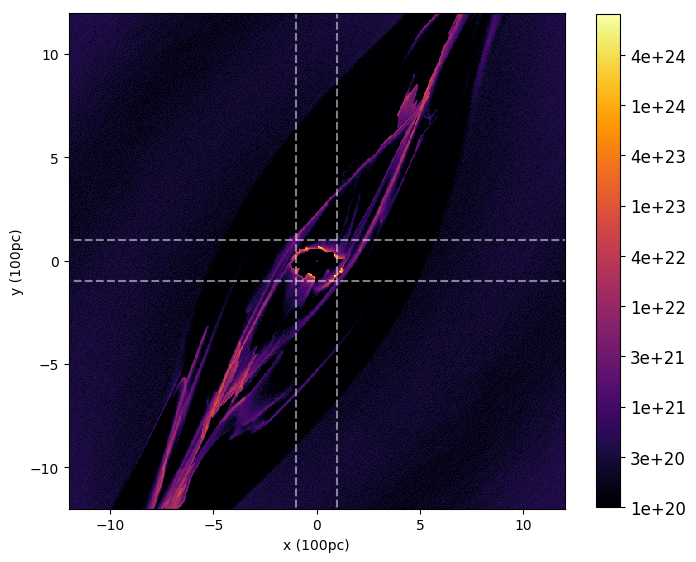

In [211]:
##############################
### Plot top down surface density
##############################

x,y,z = data['pos'].T
x,y,z = x-120, y-120, z-120
x,y = rotate(x,y,np.radians(-60))
maxx = 12.0
maxy = 12.0
plt.close()
xedges = np.linspace(-maxx,maxx,601)
yedges = np.linspace(-maxy,maxy,601)
xgrid = (xedges[:-1] + xedges[1:])/2.0
ygrid = (yedges[:-1] + yedges[1:])/2.0

dx = xedges[1] - yedges[0]
dy = yedges[1] - yedges[0]
extent = (-maxx,maxx,-maxy,maxy)

mass=snapshot.massesH2
cond= (x<maxx) & (x>-maxx) & (y<maxy) & (y>-maxy)

fig, ax = plt.subplots(1,1, figsize=(8, 8))
hist,ledges,bedges = np.histogram2d(x[cond],y[cond],bins=(xedges,yedges),
                                    weights=mass[cond])
#                                    weights=mass[cond]/(r[cond]*r[cond]))

hist = hist/(dx*dy*1e4)
hist = hist * (arepoMass) / (pc2cm**2) / (2*mH)

print hist.shape
levels = np.logspace(20,25,256)
norm   = mc.BoundaryNorm(levels,256)

my_cmap = copy.copy(plt.cm.get_cmap('inferno')) # copy the default cmap
my_cmap.set_bad((0,0,0))

im = ax.imshow(hist.T,norm=norm,extent=extent,cmap=my_cmap,origin=1)
#im = ax.imshow(hist.T,norm=colors.LogNorm(),cmap='inferno')

cb = fig.colorbar(im,format='%.0e',shrink=0.8)
cb.ax.tick_params(labelsize=12)

ax.set_ylim([-maxx,maxx])
ax.set_xlim([-maxy,maxy])

ax.plot([-1,-1],[-15,15],color='white',ls='--',alpha=0.5)
ax.plot([1,1],[-15,15],color='white',ls='--',alpha=0.5)
ax.plot([-15,15],[-1,-1],color='white',ls='--',alpha=0.5)
ax.plot([-15,15],[1,1],color='white',ls='--',alpha=0.5)

ax.set_xlabel('x (100pc)')
ax.set_ylabel('y (100pc)')
plt.show()


In [336]:
##############################
### LB historam
##############################
### transform coordinates:
### find lbr from xyz
x,y,z = data['pos'].T
x,y,z = x-120, y-120, z-120
x,y = rotate(x,y,np.radians(65+180))
z = z-0.25 ## Goodman et al 2014
l,b,r = xyz2lbr(x,y,z)
l, b = np.degrees(l), np.degrees(b)
### adjust b so you're lookin at the CMZ
#b=b-6.8 # for dz=+10
#b=b+2.5
b = b +0.17

In [337]:
#b = b +0.69

0.689148177929785


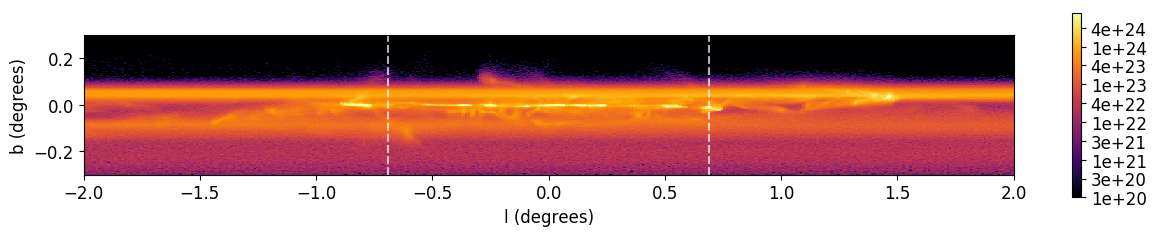

In [338]:
### build historam
maxl, maxb = 2., .3
lvals = np.linspace(-maxl,maxl,401)
bvals = np.linspace(-maxb,maxb,201)

dl = lvals[1] - lvals[0]
db = bvals[1] - bvals[0]
dx = np.radians(dl)*83.14
dy = np.radians(db)*83.14

mass=snapshot.massesH2
cond= (l<maxl) & (l>-maxl) & (b<maxb) & (b>-maxb)

plt.close()
fig, ax = plt.subplots(1,1, figsize=(15, 3))
hist,ledges,bedges = np.histogram2d(l[cond],b[cond],bins=(lvals,bvals),
                                    weights=mass[cond])

M2d_hist = hist

hist = hist/(dx*dy*1e4)
hist = hist * (arepoMass) / (pc2cm**2) / (2*mH)

levels = np.logspace(20,25,256)
norm   = mc.BoundaryNorm(levels,256)

my_cmap = copy.copy(plt.cm.get_cmap('inferno')) # copy the default cmap
my_cmap.set_bad((0,0,0))
extent = (-maxl,maxl,-maxb,maxb)

im = ax.imshow(hist.T,norm=norm,extent=extent,cmap=my_cmap,origin=1)
#im = ax.imshow(hist.T,norm=colors.LogNorm(),cmap='inferno')

cb = fig.colorbar(im,format='%.0e',shrink=0.8)
cb.ax.tick_params(labelsize=12)

l_for_100pc = np.degrees(100.0/8314.0)
print l_for_100pc
ax.plot([l_for_100pc,l_for_100pc],[-maxb,maxb],ls='--',color='white',alpha=0.7)
ax.plot([-l_for_100pc,-l_for_100pc],[-maxb,maxb],ls='--',color='white',alpha=0.7)

ax.set_ylim([-maxb,maxb])
ax.set_xlim([-maxl,maxl])

ax.set_xlabel('l (degrees)')
ax.set_ylabel('b (degrees)')
plt.show()


In [245]:
##############################
### get a 3d rotational view
### LB historam
##############################
### transform coordinates:
### find lbr from xyz
for i in range(360):
    x,y,z = data['pos'].T
    x,y,z = x-120, y-120, z-120
    x,y = rotate(x,y,np.radians(i))
    z = z-0.25
    l,b,r = xyz2lbr(x,y,z)
    l, b = np.degrees(l), np.degrees(b)
    ### adjust b so you're lookin at the CMZ
    #b=b-6.8 # for dz=+10
    #b=b+2.5
    b = b +0.17
    ### build historam
    maxl, maxb = 2., .3
    lvals = np.linspace(-maxl,maxl,401)
    bvals = np.linspace(-maxb,maxb,201)

    dl = lvals[1] - lvals[0]
    db = bvals[1] - bvals[0]
    dx = np.radians(dl)*83.14
    dy = np.radians(db)*83.14

    mass=snapshot.massesH2
    cond= (l<maxl) & (l>-maxl) & (b<maxb) & (b>-maxb)

    plt.close()
    fig, ax = plt.subplots(1,1, figsize=(15, 3))
    hist,ledges,bedges = np.histogram2d(l[cond],b[cond],bins=(lvals,bvals),
                                        weights=mass[cond])

    M2d_hist = hist

    hist = hist/(dx*dy*1e4)
    hist = hist * (arepoMass) / (pc2cm**2) / (2*mH)

    levels = np.logspace(20,25,256)
    norm   = mc.BoundaryNorm(levels,256)

    my_cmap = copy.copy(plt.cm.get_cmap('inferno')) # copy the default cmap
    my_cmap.set_bad((0,0,0))
    extent = (-maxl,maxl,-maxb,maxb)

    im = ax.imshow(hist.T,norm=norm,extent=extent,cmap=my_cmap,origin=1)
    #im = ax.imshow(hist.T,norm=colors.LogNorm(),cmap='inferno')

    cb = fig.colorbar(im,format='%.0e',shrink=0.8)
    cb.ax.tick_params(labelsize=12)

    l_for_100pc = np.degrees(100.0/8314.0)
    #print l_for_100pc
    ax.plot([l_for_100pc,l_for_100pc],[-maxb,maxb],ls='--',color='white',alpha=0.7)
    ax.plot([-l_for_100pc,-l_for_100pc],[-maxb,maxb],ls='--',color='white',alpha=0.7)

    ax.set_ylim([-maxb,maxb])
    ax.set_xlim([-maxl,maxl])

    ax.set_xlabel('l (degrees)')
    ax.set_ylabel('b (degrees)')
    plt.savefig('/Users/hph/arepo_simulations/arepo_sims_hpc/snap_2d_projection_3-19-19/lb_rotation/lb_nh2_%03d.png'%i)
    print "saved fig %03d"%i

saved fig 000
saved fig 001
saved fig 002
saved fig 003
saved fig 004
saved fig 005
saved fig 006
saved fig 007
saved fig 008
saved fig 009
saved fig 010
saved fig 011
saved fig 012
saved fig 013
saved fig 014
saved fig 015
saved fig 016
saved fig 017
saved fig 018
saved fig 019
saved fig 020
saved fig 021
saved fig 022
saved fig 023
saved fig 024
saved fig 025
saved fig 026
saved fig 027
saved fig 028
saved fig 029
saved fig 030
saved fig 031
saved fig 032
saved fig 033
saved fig 034
saved fig 035
saved fig 036
saved fig 037
saved fig 038
saved fig 039
saved fig 040
saved fig 041
saved fig 042
saved fig 043
saved fig 044
saved fig 045
saved fig 046
saved fig 047
saved fig 048
saved fig 049
saved fig 050
saved fig 051
saved fig 052
saved fig 053
saved fig 054
saved fig 055
saved fig 056
saved fig 057
saved fig 058
saved fig 059
saved fig 060
saved fig 061
saved fig 062
saved fig 063
saved fig 064
saved fig 065
saved fig 066
saved fig 067
saved fig 068
saved fig 069
saved fig 070
saved 

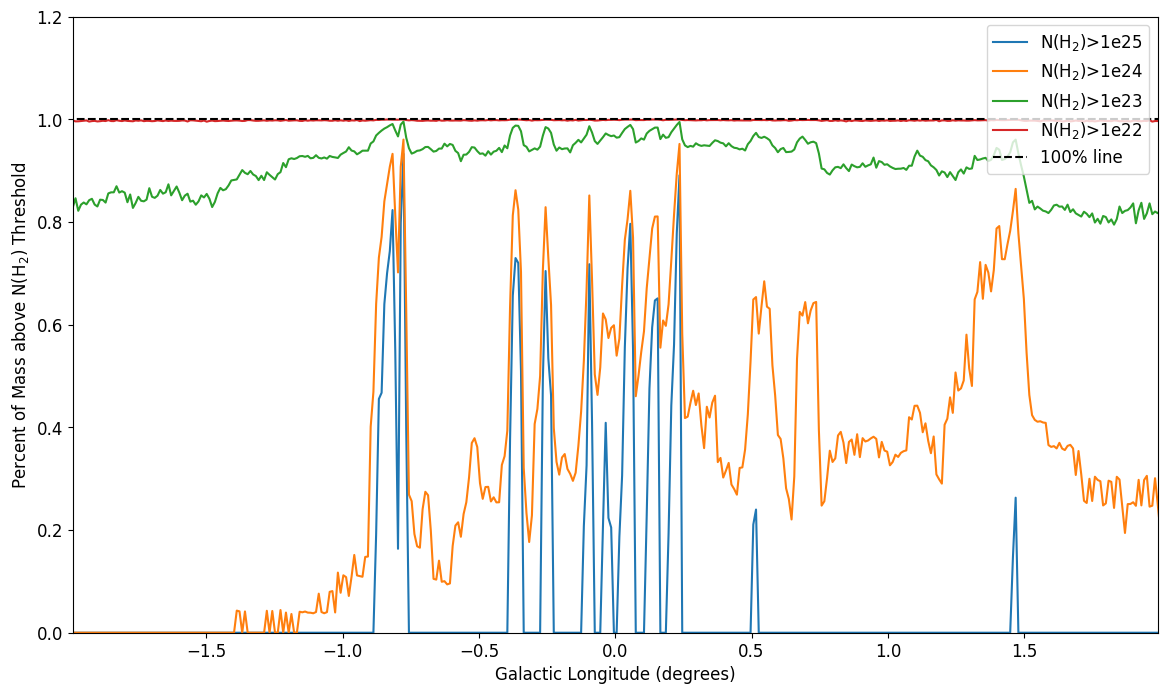

In [339]:
##############################
### DENSE gas frac LB space
##############################
plt.close()
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,1, figsize=(14, 8))

### build historam
mass=snapshot.massesH2
cond= (l<maxl) & (l>-maxl) & (b<maxb) & (b>-maxb)
M_hist,ledges = np.histogram(l[cond],bins=(lvals),
                                    weights=mass[cond])

N_hist = hist

xhn = 1e25
hn = 1e24
mn = 1e23
ln = 1e22

nl = 400
ledges = np.linspace(-maxl,maxl,nl)
ny = 60

xhighN = np.linspace(-maxl,maxl,nl)
highN = np.linspace(-maxl,maxl,nl)
midN = np.linspace(-maxl,maxl,nl)
lowN = np.linspace(-maxl,maxl,nl)
for i in range(nl):
    #xhighN[i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>xhn)[0])])
    xhighN[i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>xhn)[0])])/M_hist[i]
    highN[i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>hn)[0])])/M_hist[i]
    midN[i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>mn)[0])])/M_hist[i]
    lowN[i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>ln)[0])])/M_hist[i]

    
ax.plot(ledges,xhighN,label='N(H$_2$)>1e25')
ax.plot(ledges,highN,label='N(H$_2$)>1e24')
ax.plot(ledges,midN,label='N(H$_2$)>1e23')
ax.plot(ledges,lowN,label='N(H$_2$)>1e22')
ax.plot([-4.8,4.8],[1,1],ls='--',color='k',label='100% line')

#ax.set_yscale('log')
ax.set_xlabel('Galactic Longitude (degrees)')
ax.set_ylabel('Percent of Mass above N(H$_2$) Threshold')
ax.legend(loc='upper right')
ax.set_ylim(0,1.2)
ax.set_xlim(-1.99,1.99)

plt.show()

In [182]:
print len(xhighN)
print M2d_hist[0,:].shape
print len(np.where(N_hist[i,:]>1e24)[0])

400
(200,)
0


In [162]:
print sum(M2d_hist[:,0]>1e2)

378


In [340]:
##############################
### DENSE gas frac LB space
##############################

### build historam
mass=snapshot.massesH2
cond= (l<maxl) & (l>-maxl) & (b<maxb) & (b>-maxb)
M_hist,ledges = np.histogram(l[cond],bins=(lvals),
                                    weights=mass[cond])

N_hist = hist

nl = 400
ledges = np.linspace(-maxl,maxl,nl)
ny = 60

Nrange = np.logspace(np.log10(1.0e22),np.log10(1.0e25),256)

percent_vals = np.zeros((len(Nrange),len(ledges)))

for j in range(256):
    for i in range(nl):
        percent_vals[j,i] = np.sum(M2d_hist[i,(np.where(N_hist[i,:]>Nrange[j])[0])])/M_hist[i]
    


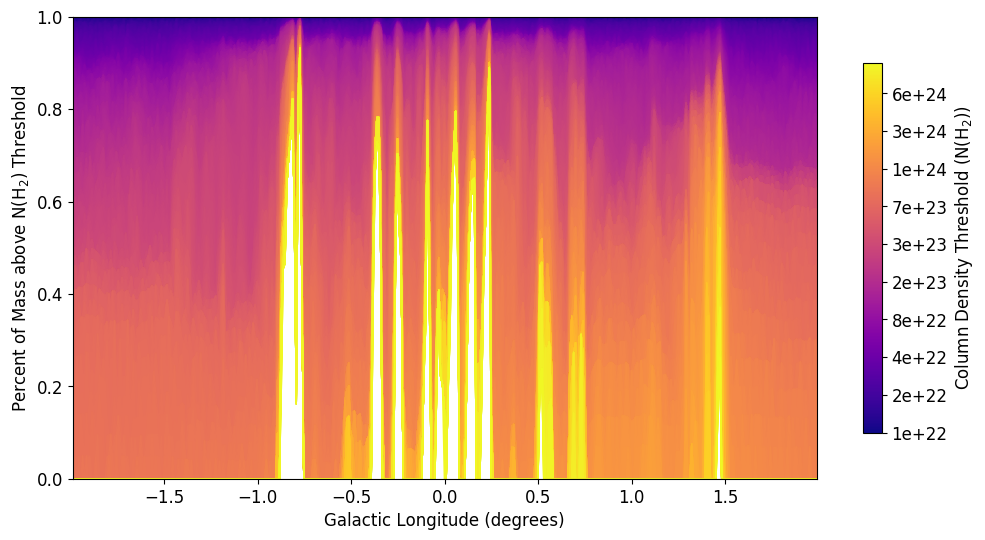

In [341]:
####################
### Plotting for the mass percents made above
####################
fig, ax = plt.subplots(1,1,figsize=(12, 6))
Z = [[0,0],[0,0]]
levels = np.logspace(22,25,256)
norm   = mc.BoundaryNorm(levels,256)
my_cmap = copy.copy(plt.cm.get_cmap('plasma')) # copy the default cmap

levels = Nrange
CS3 = ax.imshow(Z,norm=norm,cmap=my_cmap)
#CS3 = ax.contourf(Z,levels,norm=colors.LogNorm(), cmap='plasma')
plt.clf()

plt.close()
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,1,figsize=(12, 6))
colors = plt.cm.get_cmap('plasma')

for i in range(255):
    ax.fill_between(ledges,percent_vals[i+1,:],percent_vals[i,:],color=(colors(float(i)/256)))

#ax.plot([-4.8,4.8],[1,1],ls='--',color='k',label='100% line')

ax.set_xlabel('Galactic Longitude (degrees)')
ax.set_ylabel('Percent of Mass above N(H$_2$) Threshold')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
ax.set_xlim(-1.99,1.99)
#ax.set_yscale('log')



# cmap = mpl.cm.plasma
# norm = mpl.colors.LogNorm(vmin=1e21, vmax=1e27)
# cb1 = fig.add_axes([0.75,0.1,0.9,0.9])
# cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
#                                 norm=norm,
#                                 orientation='horizontal')
cb = plt.colorbar(CS3,format='%.0e',shrink=0.8)
cb.set_label('Column Density Threshold (N(H$_2$))')

plt.show()


In [286]:

print colors(0.1)

(0.254627, 0.013882, 0.615419, 1.0)


In [271]:
print len(np.where(percent_vals!=0)[0])
print percent_vals.shape

77365
(256, 400)


In [287]:
print (colors(float(4)/256))

(0.096379, 0.025165, 0.547103, 1.0)
